# Music Informatics Final Project

                                                                                                              Chou-Yin,Chen

## Topic: Classification on Music Genres

In this project, I apply the famous dataset for music genres classification- the GTZAN dataset. This dataset consists of 1000 audio tracks each 30 seconds long. It contains 10 genres, each represented by 100 tracks. The tracks are all 22050Hz Mono 16-bit audio files in .wav format. 

The reason why I choosed this topic is that I wanted to classify the genres of music in my home country- Taiwan. My favorite hobby is to play the guitar. Thus, I have the chance to access different indie musics in Taiwan, and some of them interpreted the music by using only few instruments or even only one guitar very well. Even though these bands played the music brilliantly, but different types of music are mixed together when I listen to the play list. Besides, the app for indie musics renew the songs so quickly that I have to spend a lot of time on classifying the list. Thus, I would like to dig into the topic of classification on music genres to save my time.

Since I just finished the machine learning lesson in KTH, the most important part that I will focus on will be feature extraction. Instead of the original GTZAN dataset features, including MFCC, spectral centroid, spectral bandwidth, etc, I will extract some of the features from the GTZAN sound files. Finally, the features will be the input of a random forest to test the error performance.

## Pipeline of Machine Learning:

#### 1. Data collection: 
Utilize the GTZAN dataset for the following project. 

#### 2. Feature selection: 
- Adopt the 26 important features of GTZAN dataset including the followings: Chroma Short-Time-Fourier-Transform(STFT), Root Mean Square Error(RMSE), spectral centroid, spectral bandwidth, roll off, zero crossings and 20 different MFCC features. 
- Extract new features including important tones of music and features describing the sense of rhythm.

#### 3. Preprocessing:
Normalize the training features, which helps improve the performance.

#### 4. Train model and Result:
- Adopt Random Tree and Boosting for examing the performance of the model. Use Random Tree for comparing with different conditions mostly.
- the ratio of training dataset and test dataset is 8:2.
- In the result, we do the same experiment for 100 times and calculate the average f1-score, which serve as the judgement on error performance. Besides, one of the experiment's detailed classification report will be revealed, too.
- The features of 26 important features of GTZAN dataset will be compared and combined together with the new features we extract in the following sections.

#### Import python library:

In [3]:
# Library
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pydub
import librosa
import pandas as pd
import seaborn as sn
import math
import sklearn
import imageio # save matrix as picture

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import csv

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# The following makes the plot look nice
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

#### Functions: 
This part is the functions we will apply in the extracting process.

In [86]:
# Functions
# For file input
def int_to_string(number):
    if number>=10: return('.000' + str(number))
    else: return('.0000'+ str(number))
    
# Return the features we want in Chrogram
# ratio of other notes with the root note 
def ReturnChordFeature(Chromagram):
    Features = np.zeros(12) # 12-tone technique
    
    # root node sequence
    RootNodes = np.zeros(Chromagram.shape[1])
    MaxNodes = RootNodes
    for i in range(Chromagram.shape[1]):
        MaxNodes[i] = np.argmax(Chromagram[:,i])
    onesideinterval = 2
    for i in range(Chromagram.shape[1]):
        boundfront = i-onesideinterval
        if boundfront < 0: boundfront=0
        boundend = i+onesideinterval
        if boundend >= Chromagram.shape[1]: boundfront=Chromagram.shape[1]-1
        MaxNodes = MaxNodes.astype(np.int)
        countmatrix = np.bincount(MaxNodes[boundfront:boundend])
        RootNodes[i] = np.argmax(countmatrix)
    RootNodes = RootNodes.astype(np.int)
    
    neglectednumber = 0
    for i in range(Chromagram.shape[1]):
        Maxindex = np.argmax(Chromagram[:,i])
        
        # Operation 'neglect'
        if Maxindex != RootNodes[i]: 
            continue 
            neglectednumber+=1;
        # End
        
        Maxindex = RootNodes[i]
        # focus on second, third, fourth, seventh, tenth, eleventh
        #Features[1]+=(Chromagram[(Maxindex+1)%12][i]/Chromagram[Maxindex,i])
        #Features[2]+=(Chromagram[(Maxindex+2)%12][i]/Chromagram[Maxindex,i])
        #Features[3]+=(Chromagram[(Maxindex+3)%12][i]/Chromagram[Maxindex,i])
        #Features[4]+=(Chromagram[(Maxindex+4)%12][i]/Chromagram[Maxindex,i])
        #Features[7]+=(Chromagram[(Maxindex+7)%12][i]/Chromagram[Maxindex,i])
        #Features[10]+=(Chromagram[(Maxindex+10)%12][i]/Chromagram[Maxindex,i])
        #Features[11]+=(Chromagram[(Maxindex+11)%12][i]/Chromagram[Maxindex,i])
        for tone12 in np.arange(1,12,1):
            Features[tone12]+=(Chromagram[(Maxindex+tone12)%12][i]/Chromagram[Maxindex,i])
    for i in range(12):
        Features[i]/=(Chromagram.shape[1]-neglectednumber)
    return Features

def MovingAverage(sample,Onesidefilterlength):
    size = sample.shape[0]
    Returnsample = np.zeros(size)
    for i in range(size):
        boundfront = i - Onesidefilterlength
        boundend = i + Onesidefilterlength
        if boundfront<0: boundfront = 0;
        if boundend>=size: boundend = size-1;
        Returnsample[i] = np.sum(sample[boundfront:boundend])/(boundend-boundfront)
    return Returnsample

def SenseofRhythm(path,FrameExtension):
    Returnvector = np.zeros(6)
    
    soundsamples_asAudioSegment = pydub.AudioSegment.from_file(path, format="wav")
    soundsamples_asAudioSegment = soundsamples_asAudioSegment.set_channels(1) # make single channel
    samplerate = soundsamples_asAudioSegment.frame_rate # get sample rate
    numsamples = soundsamples_asAudioSegment.frame_count() # get number of samples
    soundsamples = np.divide(soundsamples_asAudioSegment.get_array_of_samples(), 
                         soundsamples_asAudioSegment.max_possible_amplitude)
    
    onsets_frames = librosa.onset.onset_detect(soundsamples)
    onsets_frames = onsets_frames[1:-1]
    
    # moving average
    #soundsamples = MovingAverage(soundsamples,3)
    
    STFTResult = abs(librosa.stft(soundsamples))
    
    # Four returning features
    LowFreq = 0          # 0~80Hz
    MediumLowFreq = 0    # 80~320Hz
    MediumFreq = 0       # 320~1280Hz
    LowFreqRatio = 0
    MediumLowFreqRatio = 0 
    MediumFreqRatio = 0
    
    LowTemp = 0
    MLowTemp = 0
    MediumTemp = 0
    TimeLength = 0
    temp = 0
    
    for onsets in range(onsets_frames.shape[0]):
        LowFreq+=np.sum(STFTResult[0:4, onsets_frames[onsets]:onsets_frames[onsets]+FrameExtension])
        MediumLowFreq+=np.sum(STFTResult[4:16, onsets_frames[onsets]:onsets_frames[onsets]+FrameExtension])
        MediumFreq+=np.sum(STFTResult[16:64, onsets_frames[onsets]:onsets_frames[onsets]+FrameExtension])
        
        if(onsets<onsets_frames.shape[0]-1 and (onsets_frames[onsets+1]-onsets_frames[onsets]) > (FrameExtension + 2)):
            temp = onsets_frames[onsets+1] - onsets_frames[onsets] - FrameExtension - 2
            TimeLength+=temp
            LowTemp += np.sum(STFTResult[0:4, onsets_frames[onsets]+4:onsets_frames[onsets+1]-1])
            MLowTemp += np.sum(STFTResult[4:16, onsets_frames[onsets]+4:onsets_frames[onsets+1]-1])
            MediumTemp += np.sum(STFTResult[16:64, onsets_frames[onsets]+4:onsets_frames[onsets+1]-1])
        
    scalar = TimeLength/FrameExtension/onsets_frames.shape[0]
    LowFreqRatio = LowFreq*scalar/LowTemp
    MediumLowFreqRatio = MediumLowFreq*scalar/MLowTemp
    MediumFreqRatio = MediumFreq*scalar/MediumTemp
    
    Returnvector[0] = LowFreq/onsets_frames.shape[0]/12
    Returnvector[1] = MediumLowFreq/onsets_frames.shape[0]/36
    Returnvector[2] = MediumFreq/onsets_frames.shape[0]/144
    Returnvector[3] = LowFreqRatio
    Returnvector[4] = MediumLowFreqRatio
    Returnvector[5] = MediumFreqRatio
    
    return(Returnvector)

# Not completed yet
# Moving average filter
# 1. Square Error(using moving average) 2. small scale zero-crossing
def MSEusingFIRfilter(InputAmplitude,onesideinterval):
    # shorten song length
    shortenscale = 30
    # undersampling
    undersamplefactor = 1
    size = int(np.floor(InputAmplitude.shape[0]/undersamplefactor/shortenscale))
    SampledInput = np.zeros(size)
    for i in range(int(np.floor(size/shortenscale))):
        SampledInput[i]=InputAmplitude[i*undersamplefactor]

    # Calculate metric
    MSE = 0
    smallscaleZC = 0
    for timeindex in range(size):
        boundfront = timeindex - onesideinterval
        boundend = timeindex + onesideinterval
        if timeindex < onesideinterval:  boundfront = 0;
        if timeindex > size - onesideinterval: boundend = size - 1;
        average = 0
        for runningindex in np.arange(boundfront,boundend,1):
            average+=SampledInput[runningindex]
        average/=(boundend-boundfront+1)
        for runningindex in np.arange(boundfront,boundend - 1,1):
            if(SampledInput[runningindex]-average)* \
            (SampledInput[(runningindex+1)]-average)<0: smallscaleZC+=1;
        MSE+=(SampledInput[timeindex]-average)**2
    smallscaleZC/=size
    MSE/=size
    return math.sqrt(MSE), smallscaleZC

#### Main function for reading files from GTZAN dataset:

In [87]:
import librosa.display

# Build dictionary 
DictList = ['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock']

# Constants
samplerate = 44100
windowsizeinseconds = 100/1000.0
windowhopsizeinseconds = 10/1000.0
windowoverlapinseconds = windowsizeinseconds - windowhopsizeinseconds
windowsizeinsamples = int(np.ceil(windowsizeinseconds*samplerate))
windowoverlapinsamples = int(np.ceil(windowoverlapinseconds*samplerate))
windowhopsizeinsamples = windowsizeinsamples - windowoverlapinsamples

# Traversal in files
songnumber = 100

ChordFeatures  = np.zeros((len(DictList),songnumber,12))  # tone features
ChordFeatures2 = np.zeros((len(DictList),songnumber,4))
ChordFeatures3 = np.zeros((len(DictList),songnumber,6))   # rhythm features

for genre in range(len(DictList)):
    print(DictList[genre],', ',genre,'/',len(DictList))
    for songID in range(songnumber):
        #if songID%10==0: print(songID);
        if(genre==5 and songID==54): 
            ChordFeatures[genre][songID] = np.full([1,12], np.nan)
            continue
        # Read file
        pathname = "./path/" + DictList[genre] + "/" + DictList[genre] + int_to_string(songID) + ".wav"
        soundsamples_asAudioSegment = pydub.AudioSegment.from_file(pathname, format="wav")
        soundsamples_asAudioSegment = soundsamples_asAudioSegment.set_channels(1) # make single channel
        numsamples = soundsamples_asAudioSegment.frame_count() # get number of samples
        soundsamples = np.divide(soundsamples_asAudioSegment.get_array_of_samples(), 
                         soundsamples_asAudioSegment.max_possible_amplitude)
        #print(soundsamples.shape)
        
        # 1. Tone extraction
        chromagram=librosa.feature.chroma_stft(soundsamples, sr=samplerate,window='hann', n_fft=4410,
                                                 hop_length=2205)
        #librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', 
        #                         hop_length=windowhopsizeinsamples, cmap='coolwarm')
        ChordFeatures[genre][songID] = ReturnChordFeature(chromagram)
        
        # 2. 
        ChordFeatures3[genre][songID] = SenseofRhythm(pathname,2)
        
        '''
        # 3. Other Applications 
        FIRMSE, smallscaleZC= MSEusingFIRfilter(soundsamples,10)
        ChordFeatures2[genre][songID][0] = FIRMSE
        ChordFeatures2[genre][songID][1] = smallscaleZC
        FIRMSE, smallscaleZC= MSEusingFIRfilter(soundsamples,100)
        ChordFeatures2[genre][songID][2] = FIRMSE
        ChordFeatures2[genre][songID][3] = smallscaleZC
        '''
print('End of reading file process!')
soundsamples_asAudioSegment

blues ,  0 / 10
classical ,  1 / 10
country ,  2 / 10
disco ,  3 / 10
hiphop ,  4 / 10
jazz ,  5 / 10
metal ,  6 / 10
pop ,  7 / 10
reggae ,  8 / 10
rock ,  9 / 10
End of reading file process!


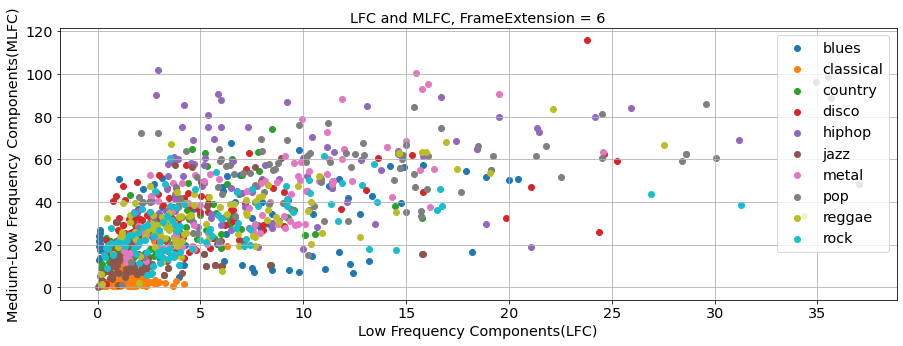

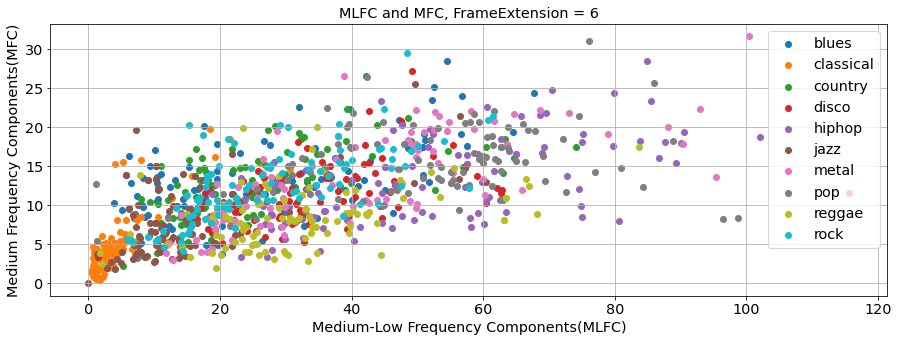

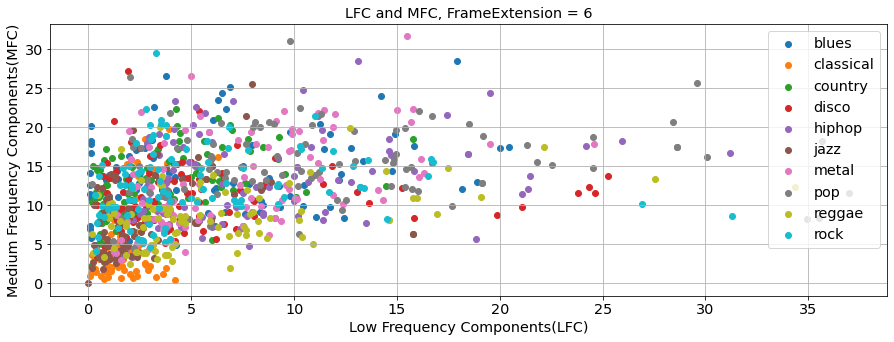

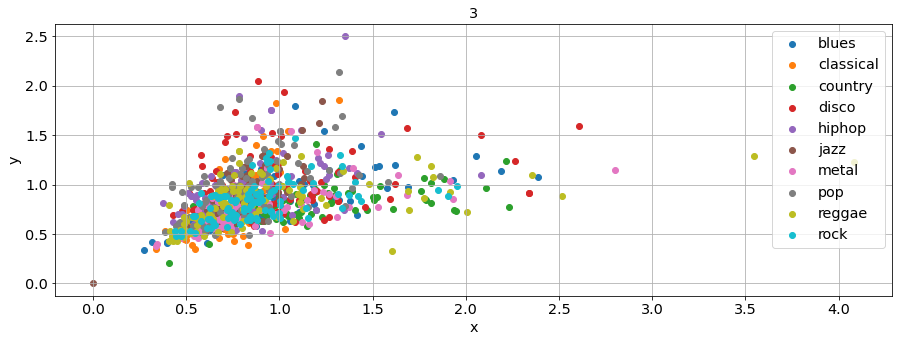

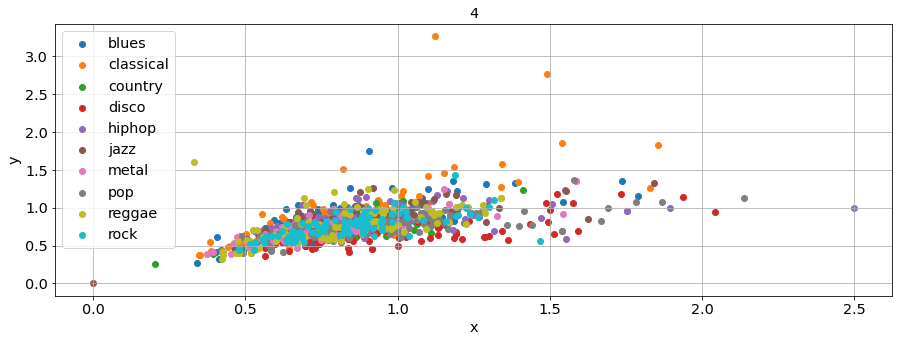

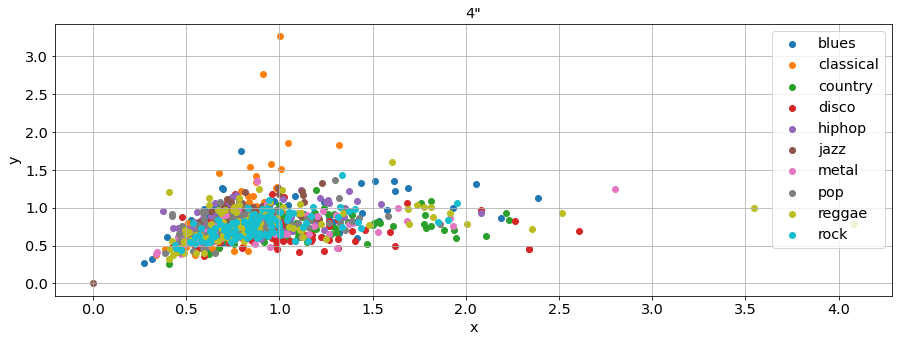

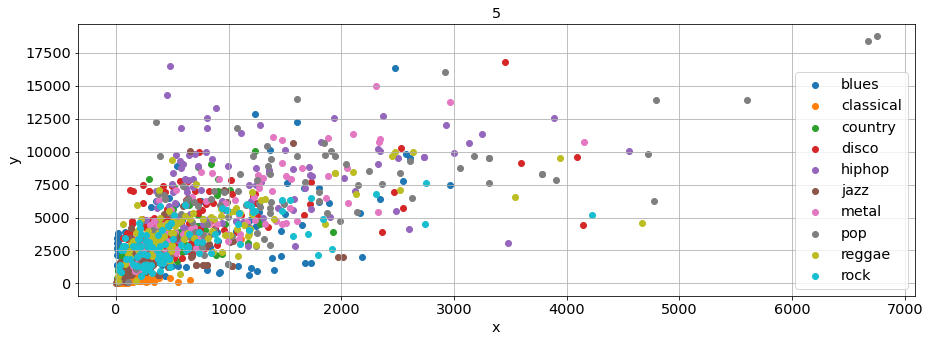

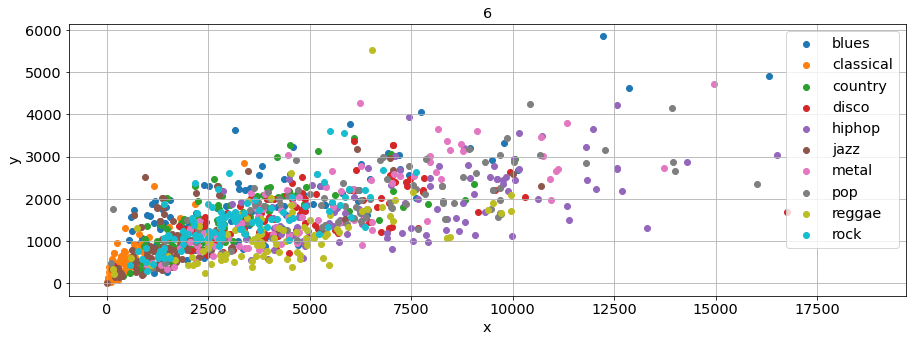

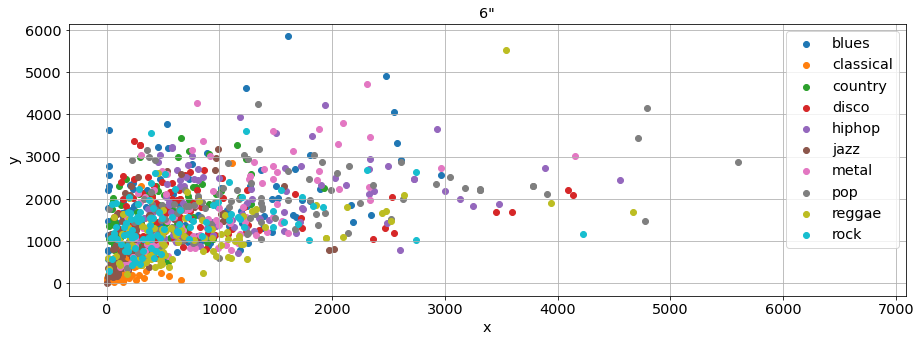

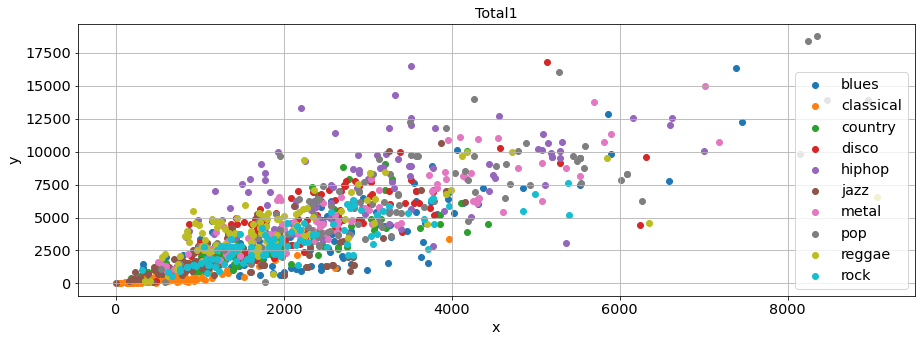

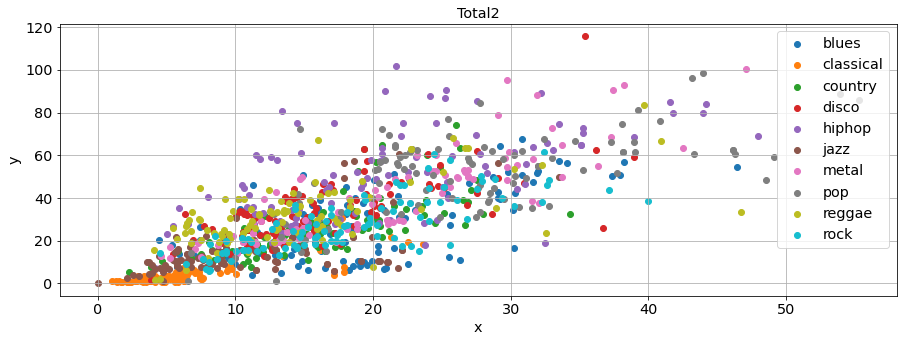

In [40]:
# Test

'''
    Returnvector[0] = LowFreq/onsets_frames.shape[0]/12
    Returnvector[1] = MediumLowFreq/onsets_frames.shape[0]/36
    Returnvector[2] = MediumFreq/onsets_frames.shape[0]/144
    Returnvector[3] = LowFreqRatio
    Returnvector[4] = MediumLowFreqRatio
    Returnvector[5] = MediumFreqRatio
    Returnvector[6] = LowFreq/12
    Returnvector[7] = MediumLowFreq/36
    Returnvector[8] = MediumFreq/144
    Returnvector[9] = LowFreqRatio/scalar
    Returnvector[10] = MediumLowFreqRatio/scalar
    Returnvector[11] = MediumFreqRatio/scalar
'''
# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,0], ChordFeatures3[i,:,1])
    
plt.title('LFC and MLFC, FrameExtension = 6'); plt.grid()
plt.xlabel('Low Frequency Components(LFC)'); plt.ylabel('Medium-Low Frequency Components(MLFC)')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.savefig('./figures/LFC and MLFC 6.png')
plt.show()

# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,1],ChordFeatures3[i,:,2])
    
plt.title('MLFC and MFC, FrameExtension = 6'); plt.grid()
plt.xlabel('Medium-Low Frequency Components(MLFC)'); plt.ylabel('Medium Frequency Components(MFC)')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.savefig('./figures/MLFC and MFC 6.png')
plt.show()

for i in range(10):
    plt.scatter(ChordFeatures3[i,:,0], ChordFeatures3[i,:,2])
    
plt.title('LFC and MFC, FrameExtension = 6'); plt.grid()
plt.xlabel('Low Frequency Components(LFC)'); plt.ylabel('Medium Frequency Components(MFC)')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.savefig('./figures/LFC and MFC 6.png')
plt.show()

# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,3],ChordFeatures3[i,:,4])
    
plt.title('3'); plt.grid()
plt.xlabel('x'); plt.ylabel('y')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/majorchord_ratio.png')
plt.show()


# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,4], ChordFeatures3[i,:,5])
    
plt.title('4'); plt.grid()
plt.xlabel('x'); plt.ylabel('y')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/majorchord_ratio.png')
plt.show()

# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,3], ChordFeatures3[i,:,5])
    
plt.title('4"'); plt.grid()
plt.xlabel('x'); plt.ylabel('y')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/majorchord_ratio.png')
plt.show()

# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,6],ChordFeatures3[i,:,7])
    
plt.title('5'); plt.grid()
plt.xlabel('x'); plt.ylabel('y')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/majorchord_ratio.png')
plt.show()

# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,7],ChordFeatures3[i,:,8])
    
plt.title('6'); plt.grid()
plt.xlabel('x'); plt.ylabel('y')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/majorchord_ratio.png')
plt.show()

# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,6],ChordFeatures3[i,:,8])
    
plt.title('6"'); plt.grid()
plt.xlabel('x'); plt.ylabel('y')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/majorchord_ratio.png')
plt.show()

# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,6] + ChordFeatures3[i,:,8],
                ChordFeatures3[i,:,7])
    
plt.title('Total1'); plt.grid()
plt.xlabel('x'); plt.ylabel('y')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/majorchord_ratio.png')
plt.show()

# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,0] + ChordFeatures3[i,:,2],
                ChordFeatures3[i,:,1])
    
plt.title('Total2'); plt.grid()
plt.xlabel('x'); plt.ylabel('y')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/majorchord_ratio.png')
plt.show()

## Feature extraction:

### 1. Extraction from tones of music :

Chord is one of the most important elements in the music. In different genres of music, the songs usaually like to use different kinds of chord progression. For instance, jazz music likes to implement some unharmonic or intense chords such as Major 9, and pop music likes to implement classic chord progression such as 1-5-6-4. Thus, some features will be extracted from the chords in the dataset to help training the data. There are many methods to figure out the chord progression of a song, including Viterbi algorithm and HMM-based chord recognization. Here we apply the basic method- the template-based algorithm. 

The main idea is to extract the tones of music data via chroma in the python library librosa. There are many kinds of chords existing now. Here we analyze the most important ones including the major fifth chord, minor fifth chord, seventh chord and ninth chord. The component tones of major fifth chord is root note, major third and fifth, and the component tones of minor fifth chord is root note, minor third and fifth. On the other hand, seventh chord contains extra seventh tones including major seventh and minor seventh. Simalarily, ninth chord contains extra ninth tones(or second tones) including major ninth and minor ninth. To put it in the nutshell, we are going to analyze seven different tones, involving the major and minor second, the major and minor third, the fifth, the major and the minor seventh. Totally seven tones are adopted for the new features. 

#### Algorithm 1: Extracting tones

Firstly, the chroma is extracted by using the library 'librosa'. In this part, we have to choose a long window, since the feature of chord is also in a longer duration. If the window is too small, it is easily to change chords in a very short time, which is not possible at all in real life songs. 

Secondly, we apply the function 'ReturnChordFeature'. Find the maximum values in each column in chroma diagram, and these values are defined as the maximum notes. Basically, these notes should be selected as the root notes in each time period, but sometimes some mis-detection will leads to the fact that the root notes changes vastly in a short time. Thus, we apply a vote mechanism to recheck each root notes. Each selected maximum notes will compare with its neighbors (2 in the right and 2 in the left). The result of that note will be decided by voting, and the result notes are denoted as the final rootnotes. The reason we chooses 4 neigbors is that the total considered notes will be 5 (including itself), and the time duration will be around 0.25 second (according to the parameters of chroma), which is a suitable choice for a chord progression. However, we still cannot guarantee that the root note is the right one. Thus, we apply an operation 'neglect' for deleting the unsured information. The 'neglect' operation is to neglect the notes that have different maximum note and final rootnotes. According to figure 1 and figure 2, the f1-score after neglecting is 40.8%, and the f1-score before neglecting is 37.7%. 

Finally, the value of different tones will be normalized by the root note. The reason of doing normalization is that we don't want the loudness of the song dominate the values of the components. Then these values can be calculated and this function will return a vector. The process of extracting the components of seven different tones, involving the major and minor second, the major and minor third, the fifth, the major and the minor seventh is finished.

#### The following block is showing the result by pictures:

The classification report is only the result of one time, and the average F1-score is the result of 100 time tests.

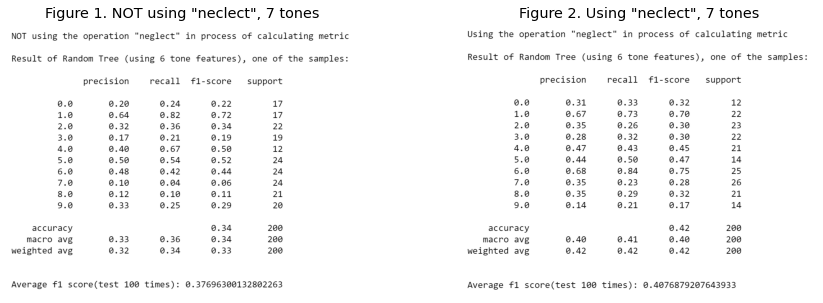

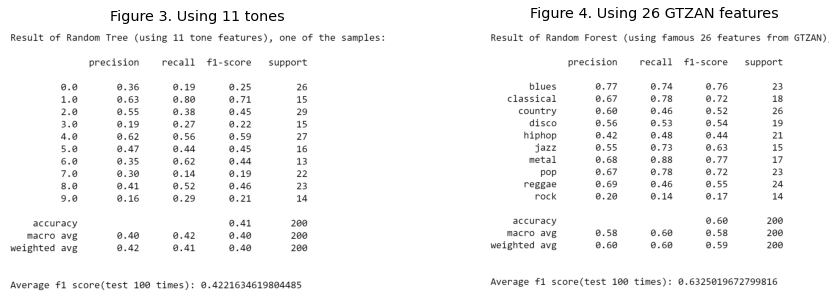

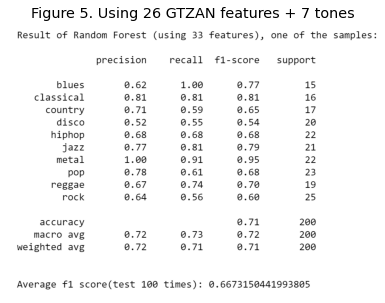

In [108]:
Nneg = mpimg.imread('./figures/Not neglect.png')
plt.figure(1)
plt.subplot(1,2,1)
plt.title('Figure 1. NOT using "neclect", 7 tones')
plt.imshow(Nneg)
plt.axis('off')

Nneg = mpimg.imread('./figures/neglect.png')
plt.subplot(1,2,2)
plt.title('Figure 2. Using "neclect", 7 tones')
plt.imshow(Nneg)
plt.axis('off')
plt.show()

plt.figure(1)
Nneg = mpimg.imread('./figures/RandomTree_11tone.png')
plt.subplot(1,2,1)
plt.title('Figure 3. Using 11 tones')
plt.imshow(Nneg)
plt.axis('off')
#plt.show()

Nneg = mpimg.imread('./figures/GTZAN_feature.png')
plt.subplot(1,2,2)
plt.title('Figure 4. Using 26 GTZAN features')
plt.imshow(Nneg)
plt.axis('off')
plt.show()

Nneg = mpimg.imread('./figures/GTZAN_tones_feature.png')
plt.subplot(1,2,2)
plt.title('Figure 5. Using 26 GTZAN features + 7 tones')
plt.imshow(Nneg)
plt.axis('off')
plt.show()

#### Result for extracting tones:

#### (1) Scatter diagrams:

Firstly, we observe the result via the scatter diagram. We observe the features in pairs with four diagram, including the 
major fifth chord, minor fifth chord, seventh chord and ninth chord. Seven features will be illustrated in four diagrams with some of them overlapped. In these figures, classicals are the most seperated groups comparing with others, especially in the diagram of seventh chord and ninth chord. 

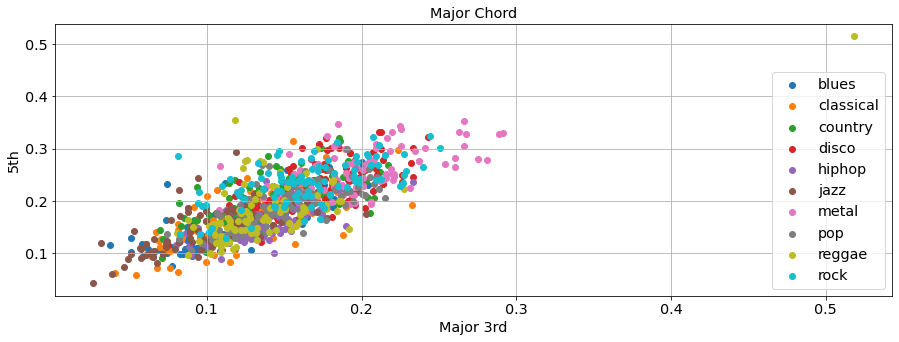

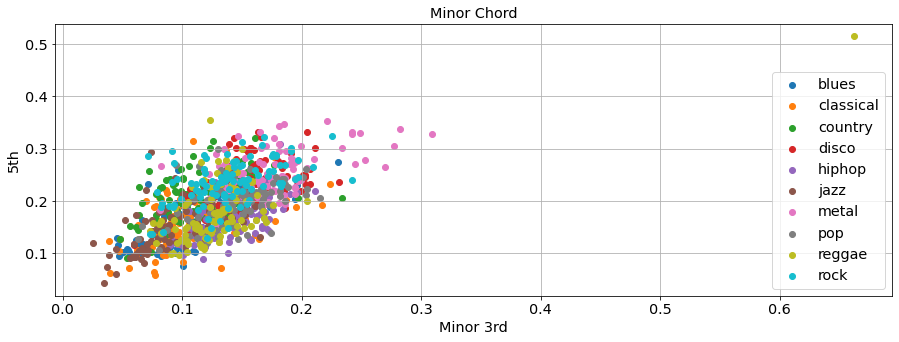

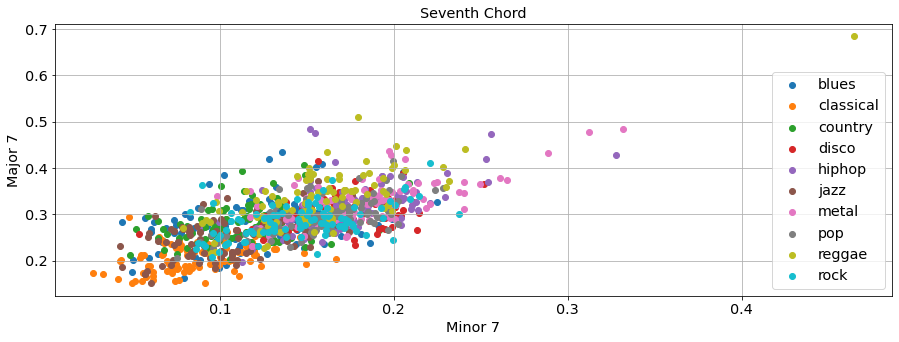

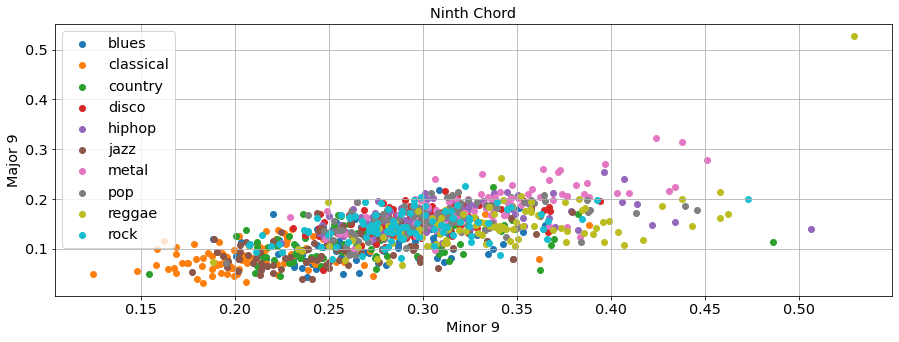

"\n# Show result from the pictures\nPic_major = mpimg.imread('./figures/majorchord_ratio.png')\nPic_minor = mpimg.imread('./figures/minorchord_ratio.png')\nPic_7th = mpimg.imread('./figures/seventhchord_ratio.png')\nPic_9th = mpimg.imread('./figures/ninthchord_ratio.png')\n\nplt.imshow(Pic_major)\nplt.axis('off')\nplt.show()\nplt.imshow(Pic_minor)\nplt.axis('off')\nplt.show()\nplt.imshow(Pic_7th)\nplt.axis('off')\nplt.show()\nplt.imshow(Pic_9th)\nplt.axis('off')\nplt.show()\n"

In [28]:
# Show result and produce picture
# Major
for i in range(10):
    plt.scatter(ChordFeatures[i,:,4],ChordFeatures[i,:,7])
    
plt.title('Major Chord'); plt.grid()
plt.xlabel('Major 3rd'); plt.ylabel('5th')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.savefig('./figures/majorchord_ratio.png')
plt.show()

# Minor
for i in range(10):
    plt.scatter(ChordFeatures[i,:,3],ChordFeatures[i,:,7])
plt.title('Minor Chord'); plt.grid()
plt.xlabel('Minor 3rd'); plt.ylabel('5th')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.savefig('./figures/minorchord_ratio.png')
plt.show()

# 7th
for i in range(10):
    plt.scatter(ChordFeatures[i,:,10],ChordFeatures[i,:,11])
plt.title('Seventh Chord'); plt.grid()
plt.xlabel('Minor 7'); plt.ylabel('Major 7')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.savefig('./figures/seventhchord_ratio.png')
plt.show()

# 9th
for i in range(10):
    plt.scatter(ChordFeatures[i,:,1],ChordFeatures[i,:,2])
plt.title('Ninth Chord'); plt.grid()
plt.xlabel('Minor 9'); plt.ylabel('Major 9')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.savefig('./figures/ninthchord_ratio.png')
plt.show()

'''
# If cannnot show the pictures in the previous code
# Show result from the downloaded pictures
Pic_major = mpimg.imread('./figures/majorchord_ratio.png')
Pic_minor = mpimg.imread('./figures/minorchord_ratio.png')
Pic_7th = mpimg.imread('./figures/seventhchord_ratio.png')
Pic_9th = mpimg.imread('./figures/ninthchord_ratio.png')

plt.imshow(Pic_major)
plt.axis('off')
plt.show()
plt.imshow(Pic_minor)
plt.axis('off')
plt.show()
plt.imshow(Pic_7th)
plt.axis('off')
plt.show()
plt.imshow(Pic_9th)
plt.axis('off')
plt.show()
'''

In [66]:
'''
# Write file (features in tones)
# Dimensione decrease
Dim2ChordFeatures = np.reshape(ChordFeatures,(-1,12))

ylabel = np.zeros(songnumber*len(DictList))
for i in range(len(DictList)):
    ylabel[i*songnumber:(i+1)*songnumber] = np.ones(songnumber)*i
ylabel=ylabel.astype(np.int)

# The six tones 
table = np.vstack((ylabel.transpose(),Dim2ChordFeatures[:,1].transpose()))
table = np.vstack((table,Dim2ChordFeatures[:,2].transpose()))
table = np.vstack((table,Dim2ChordFeatures[:,3].transpose()))
table = np.vstack((table,Dim2ChordFeatures[:,4].transpose()))
table = np.vstack((table,Dim2ChordFeatures[:,7].transpose()))
table = np.vstack((table,Dim2ChordFeatures[:,10].transpose()))
table = np.vstack((table,Dim2ChordFeatures[:,11].transpose()))
table = table.swapaxes(0,1)

with open('Myfeatures_tones_test.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['label', 'Minor 9', 'Major 9', 'Minor 3','Major 3','Major 5','Minor 7','Major 7'])
  writer.writerows(table)

# Other tones
table = np.vstack((ylabel.transpose(),Dim2ChordFeatures[:,5].transpose()))
table = np.vstack((table,Dim2ChordFeatures[:,6].transpose()))
table = np.vstack((table,Dim2ChordFeatures[:,8].transpose()))
table = np.vstack((table,Dim2ChordFeatures[:,9].transpose()))
table = table.swapaxes(0,1)

with open('Myfeatures_othertones.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['label', 'Degree 5', 'Degree 6', 'Degree 8', 'Degree 9'])
  writer.writerows(table)
'''
'''
# Output file (features in chords)
# Dimensione decrease
Dim2ChordFeatures = np.reshape(ChordFeatures,(-1,12))

ylabel = np.zeros(songnumber*len(DictList))
for i in range(len(DictList)):
    ylabel[i*songnumber:(i+1)*songnumber] = np.ones(songnumber)*i
ylabel=ylabel.astype(np.int)
print(ylabel.shape,Dim2ChordFeatures[:,2].shape)
table = np.vstack((ylabel.transpose(),(Dim2ChordFeatures[:,4]+Dim2ChordFeatures[:,7]).transpose()))
table = np.vstack((table,(Dim2ChordFeatures[:,3]+Dim2ChordFeatures[:,7]).transpose()))
table = np.vstack((table,(Dim2ChordFeatures[:,10]+Dim2ChordFeatures[:,11]).transpose()))
table = np.vstack((table,(Dim2ChordFeatures[:,1]+Dim2ChordFeatures[:,2]).transpose()))
table = table.swapaxes(0,1)
print(table.shape)
with open('Myfeatures_chords.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['label', 'Major', 'Minor', 'Seventh','Ninth'])
  writer.writerows(table)
'''

#### (2) F1-score of Random forest:

The result of Random forest using operation 'neglect' with 7 tones is illustrated in Figure 2, and the f1-score is 40.7%. In order to make sure that the rest of the tones are not so important, we add these tones together and try a 11 tone dataset. The result of 11 tones using Randon forest is f1-score = 42.2% in Figure 3. From this data, we ensure that the component tones of major, minor, seventh and ninth chords are the most important tones indeed. Besides, we use the famous 26 GTZAN features as a standard. The result of applying these 26 features into Randon forest is f1-score = 63.3% in Figure 4. After we add the features of 7 tones into 26 features in GTZAN dataset, the result of f1-score becomes 66.7%, and the increaseing rate of performance is 3.3%.

In [67]:
# Train data & Test
NewData = pd.read_csv('Myfeatures_tones_test.csv')
#NewDataOthers = pd.read_csv('Myfeatures_othertones.csv')
#NewData = pd.read_csv('Myfeatures_chords.csv')
NewData = NewData.dropna()
#NewDataOthers = NewDataOthers.dropna()
#print(np.array(NewData.iloc[:, 0]))
Newy = np.array(NewData.iloc[:, 0])
Scaler = StandardScaler()

#NewData = NewData.drop(['Minor 7','Major 7'], axis=1)

NewX = Scaler.fit_transform(np.array(NewData.iloc[:, 1:], dtype = float))
#NewXOthers = Scaler.fit_transform(np.array(NewDataOthers.iloc[:, 1:], dtype = float))
#NewX = np.hstack((NewX,NewXOthers))

print('Final size of the adopted data: ', NewX.shape)
F1score = 0 
samplenumber = 100
print('sample number = ',samplenumber,'\n')
for sampleindex in range(samplenumber):
    X_train, X_test, y_train, y_test = train_test_split(NewX, Newy, test_size = 0.2)

    # Train model (RF)
    classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    F1score += sklearn.metrics.f1_score(y_test, y_pred,average='weighted')
F1score/=samplenumber
#print('\nResult of Random Tree (using 4 chord features):\n')
print('Using the operation "neglect" in process of calculating metric')
print('\nResult of Random Tree (using 7 tone features), one of the samples:\n')
print(classification_report(y_test, classifier.predict(X_test)))
print('\nAverage f1 score(test',samplenumber,'times):',F1score,'\n')

'''
# Train model (Adaboost)
xg_reg = xgb.XGBClassifier()
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
print('\nResult of Boosting:\n')
print(classification_report(y_test, xg_reg.predict(X_test)))
'''

Final size of the adopted data:  (100, 7)
sample number =  100 

Using the operation "neglect" in process of calculating metric

Result of Random Tree (using 7 tone features), one of the samples:

              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         2
         1.0       0.00      0.00      0.00         1
         2.0       0.50      0.50      0.50         2
         3.0       0.00      0.00      0.00         2
         4.0       0.50      0.25      0.33         4
         5.0       1.00      0.33      0.50         3
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         2
         9.0       1.00      1.00      1.00         1

    accuracy                           0.25        20
   macro avg       0.35      0.26      0.28        20
weighted avg       0.40      0.25      0.29        20


Average f1 score(test 100 times): 0.3336986

"\n# Train model (Adaboost)\nxg_reg = xgb.XGBClassifier()\nxg_reg.fit(X_train,y_train)\npreds = xg_reg.predict(X_test)\nprint('\nResult of Boosting:\n')\nprint(classification_report(y_test, xg_reg.predict(X_test)))\n"

### Extraction from the sense of rhythm

The sense of rhythm is an indicator for classfifying different kinds of songs. The definition of the sense of ryhthm is the ability to dance or play music with the beat of accompanying music. In daily lifes, we sometimes describes a song that is full of sense of thythm when it provides strong feeling of the beats. In many cases, the rhythm is constructed by the instruments with low frequency such as drums or bass. These instruments is one of the most important elements describing the sense of rhythm. Thus, in the following section, we are going to dig into the features of the sense of rhythm.

#### Algorithm 2: Extracting the sense of rhythm:

Firstly, apply onset detection from the library of librosa to observe the onset frames. At the same time, find the STFT of the input sample. Then denote the freqeuncy components in 0 ~ 80 Hz as the Low Frequency Component(LFC), denote the freqeuncy components in 80 ~ 320Hz as the the Medium-Low Frequncy Component(MLFC), and denote the frequency components in 320 ~ 1280Hz as the Medium Frequncy Component(MFC). If the energy distribution is strong in these frequencies with onset happening, we consider this phenomenon strong sense of rhythm. 

Secondly, we set a parameter 'Frame extension' for caluculating the length of the time duration after onset happens. After the onsets happen, the energy will not turn to 0 immediately but decay in some rate. Thus, this parameter decides how long do we want to grab the energy after the phenomenon of onset. Then we calculate the energy from the STFT dataset. The result of the summation of each frequency intervals is the result of the parameters. In this process, the moving-average filter (one kind of FIR filter) was tested in order to lower the components of high frequency. In the field of wireless communication, moving-average FIR filter is used for discriminate the high frequency noise polluted by the channel. At first, I thought that using this filter can lower the interference of high frequency components, and the energy can be concentrated on the low frequency. But this method will lead to the distortion of the frequency component of low frequency. Thus, this method was not applied in the following experiment.

In order to figure out the best paramter of 'Frame Extension', a set of number was tested in numerical experiments. According to Figure 6 and 7, when the parameter is 2, the result will be the best, which is having the average F1-score of 51.4%. This result shows that when the the parameter is too big, we gather to many part of energy after the existing point of onset, and this parameter will not focus on onset energy anymore. That's why we should set a limited parameter. If the parameter continues to grow up, the result will be gathering the specific frequncy components from all the time in the song, which is not related to the sense of rhythm anymore. By the optmization of this parameter, it is reasonable to say that the logic of extracting the sense of rhythm is meaningful for classifying the music genres.

Besides, we also try to calculate the ratio of the energy of onsets and other non-onset intervals. This is because that if the ratios is bigger, usually the feeling of beats will be stronger. This can also be one of the indicators for the feeling of the sense of rhythm. These parameters are denoted as the LFC ratio, MLFC ratio and MFC ratio. Note that these parameters are also normalized by the ratio of the corresponding time intervals, so that the parameters will be fair enough.

#### The following block is showing the result by pictures:

The classification report is only the result of one time, and the average F1-score is the result of 100 time tests.

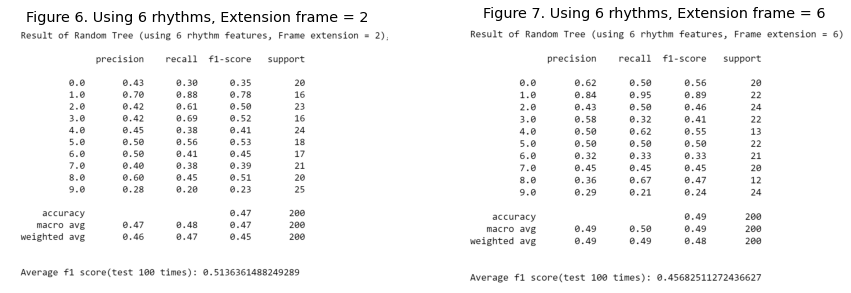

In [82]:
Nneg = mpimg.imread('./figures/RandomTree_6rhythms_EF2.png')
plt.figure(1)
plt.subplot(1,2,1)
plt.title('Figure 6. Using 6 rhythms, Extension frame = 2')
plt.imshow(Nneg)
plt.axis('off')

Nneg = mpimg.imread('./figures/RandomTree_6rhythms_EF6.png')
plt.figure(1)
plt.subplot(1,2,2)
plt.title('Figure 7. Using 6 rhythms, Extension frame = 6')
plt.imshow(Nneg)
plt.axis('off')

plt.show()

#### Result for extracting the sense of rhythm:

#### (1) Scatter diagrams:

Firstly, we observe the result via the scatter diagram. We observe the features with three diagram, comparing the LFC, MLFC and MFC. In these figures,

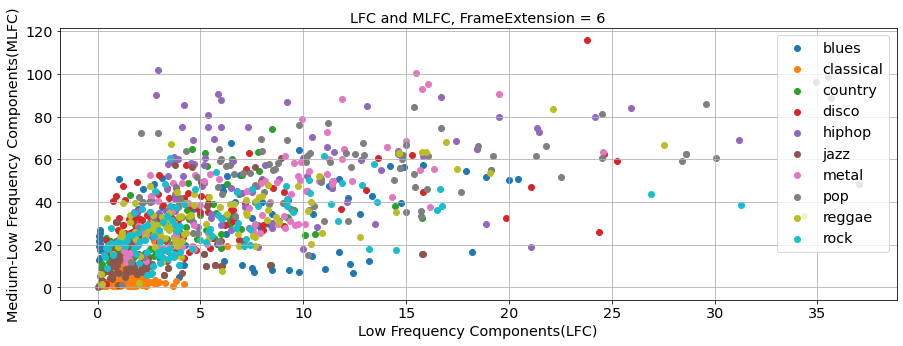

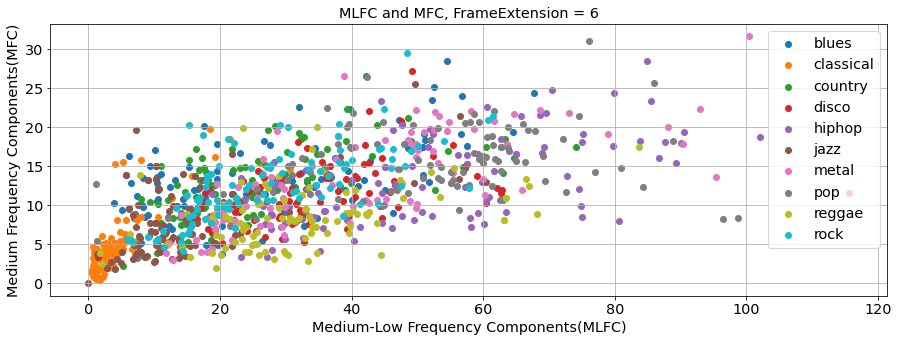

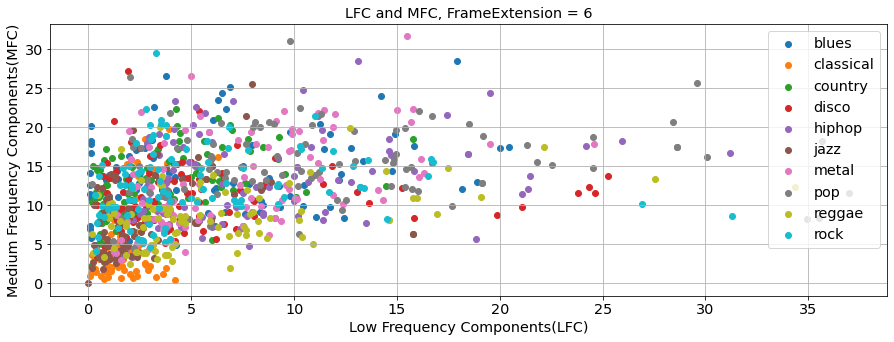

In [45]:
# Show result and produce picture
for i in range(10):
    plt.scatter(ChordFeatures3[i,:,0], ChordFeatures3[i,:,1])
    
plt.title('LFC and MLFC, FrameExtension = 6'); plt.grid()
plt.xlabel('Low Frequency Components(LFC)'); plt.ylabel('Medium-Low Frequency Components(MLFC)')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/LFC and MLFC 6.png')
plt.show()

for i in range(10):
    plt.scatter(ChordFeatures3[i,:,1],ChordFeatures3[i,:,2])
    
plt.title('MLFC and MFC, FrameExtension = 6'); plt.grid()
plt.xlabel('Medium-Low Frequency Components(MLFC)'); plt.ylabel('Medium Frequency Components(MFC)')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/MLFC and MFC 6.png')
plt.show()

for i in range(10):
    plt.scatter(ChordFeatures3[i,:,0], ChordFeatures3[i,:,2])
    
plt.title('LFC and MFC, FrameExtension = 6'); plt.grid()
plt.xlabel('Low Frequency Components(LFC)'); plt.ylabel('Medium Frequency Components(MFC)')
plt.legend(['blues', 'classical','country', 'disco', 'hiphop', 
            'jazz', 'metal', 'pop', 'reggae', 'rock'])
#plt.savefig('./figures/LFC and MFC 6.png')
plt.show()

In [83]:
# Output file (features in rhythm)
# Dimensione decrease
Dim2ChordFeatures3 = np.reshape(ChordFeatures3,(-1,6))

ylabel = np.zeros(songnumber*len(DictList))
for i in range(len(DictList)):
    ylabel[i*songnumber:(i+1)*songnumber] = np.ones(songnumber)*i
ylabel=ylabel.astype(np.int)
print(ylabel.shape,Dim2ChordFeatures3[:,2].shape)
table = np.vstack((ylabel.transpose(),(Dim2ChordFeatures3[:,0]).transpose()))
table = np.vstack((table,(Dim2ChordFeatures3[:,1]).transpose()))
table = np.vstack((table,(Dim2ChordFeatures3[:,2]).transpose()))
table = np.vstack((table,(Dim2ChordFeatures3[:,3]).transpose()))
table = np.vstack((table,(Dim2ChordFeatures3[:,4]).transpose()))
table = np.vstack((table,(Dim2ChordFeatures3[:,5]).transpose()))
table = table.swapaxes(0,1)
print(table.shape)
with open('Myfeatures_rhythm_20.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['label','LFC', 'MLFC', 'MFC','LFC ratio', 'MLFC ratio', 'MFC ratio'])
  writer.writerows(table)

(1000,) (1000,)
(1000, 7)


#### (2) F1-score of Random forest:

It is difficult to judge the parameter "Extension Frame" mentioned in the previous sections.

In [84]:
# Train data & Test
NewData = pd.read_csv('Myfeatures_rhythm_20.csv')
#NewData = pd.read_csv('Myfeatures_chords.csv')
NewData = NewData.dropna()
#print(np.array(NewData.iloc[:, 0]))
Newy = np.array(NewData.iloc[:, 0])
Scaler = StandardScaler()
NewX = Scaler.fit_transform(np.array(NewData.iloc[:, 1:], dtype = float))
print(NewX.shape)

F1score = 0 
samplenumber = 100
print('sample number = ',samplenumber,'\n')
for sampleindex in range(samplenumber):
    X_train, X_test, y_train, y_test = train_test_split(NewX, Newy, test_size = 0.2)

    # Train model (RF)
    classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    F1score += sklearn.metrics.f1_score(y_test, y_pred,average='weighted')
F1score/=samplenumber
#print('\nResult of Random Tree (using 4 chord features):\n')
#print('Using the operation "neglect" in process of calculating metric')
print('\nResult of Random Tree (using 6 rhythm features, Frame extension = 2), one of the samples:\n')
print(classification_report(y_test, classifier.predict(X_test)))
print('\nAverage f1 score(test',samplenumber,'times):',F1score,'\n')

'''
# Train model (Adaboost)
xg_reg = xgb.XGBClassifier()
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
print('\nResult of Boosting:\n')
print(classification_report(y_test, xg_reg.predict(X_test)))
'''

(631, 6)
sample number =  100 


Result of Random Tree (using 6 rhythm features, Frame extension = 2), one of the samples:

              precision    recall  f1-score   support

         0.0       0.40      0.31      0.35        13
         1.0       0.94      0.75      0.83        20
         2.0       0.15      0.25      0.19         8
         3.0       0.00      0.00      0.00         4
         4.0       0.33      0.17      0.22        12
         5.0       0.50      0.57      0.53        14
         6.0       0.25      0.38      0.30        13
         7.0       0.29      0.27      0.28        15
         8.0       0.50      0.12      0.20         8
         9.0       0.39      0.45      0.42        20

    accuracy                           0.39       127
   macro avg       0.38      0.33      0.33       127
weighted avg       0.44      0.39      0.40       127


Average f1 score(test 100 times): 0.42144126576028057 



"\n# Train model (Adaboost)\nxg_reg = xgb.XGBClassifier()\nxg_reg.fit(X_train,y_train)\npreds = xg_reg.predict(X_test)\nprint('\nResult of Boosting:\n')\nprint(classification_report(y_test, xg_reg.predict(X_test)))\n"

#### Test the result of 26 GTZAN features and combining it with other features we found in the previous sections

In [88]:
# Import features from files
data = pd.read_csv('GITZAN_data.csv')
scaler = StandardScaler()

readfileparameter = 1 # 1 = Only GTZAN data, 2 = Combining other data
if(readfileparameter==1):
    # 1. Only GTZAN data
    data1 = data.drop(['filename'],axis=1)
    data1 = data1.dropna()
    y = data1.iloc[:,-1]
    X = scaler.fit_transform(np.array(data1.iloc[:, 1:7], dtype = float))
    #X = scaler.fit_transform(np.array(data1.iloc[:, :-1], dtype = float))
else:
    # 2. Combining other data
    Label = data[['label']]
    NewData = pd.read_csv('Myfeatures_tones.csv')
    NewData = NewData.drop(['label'],axis=1)
    data = data.drop(['label'],axis=1)
    data = pd.concat( [data, NewData,Label], axis=1)
    data1 = data.drop(['filename'],axis=1)
    data1 = data1.dropna()
    y = data1.iloc[:,-1]
    X = scaler.fit_transform(np.array(data1.iloc[:, :-1], dtype = float))

# Print data parameter
print('Total',X.shape[1],'features with',X.shape[0],'songs')

Total 6 features with 1000 songs


In [90]:
# Train model (Random forest)
F1score = 0 
samplenumber = 100
for sampleindex in range(samplenumber):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    F1score += sklearn.metrics.f1_score(y_test, y_pred,average='weighted')
F1score/=samplenumber
print('\nResult of Random Forest (using famous first 6 features from GTZAN), one of the samples:\n')
#print('\nResult of Random Forest (using',X.shape[1],'features), one of the samples:\n')
print(classification_report(y_test, classifier.predict(X_test)))
print('\nAverage f1 score(test',samplenumber,'times):',F1score,'\n')


Result of Random Forest (using famous first 6 features from GTZAN), one of the samples:

              precision    recall  f1-score   support

       blues       0.50      0.36      0.42        25
   classical       0.93      0.93      0.93        28
     country       0.38      0.44      0.41        18
       disco       0.24      0.31      0.27        13
      hiphop       0.41      0.33      0.37        21
        jazz       0.28      0.31      0.29        16
       metal       0.50      0.62      0.55        21
         pop       0.75      0.67      0.71        18
      reggae       0.38      0.45      0.41        20
        rock       0.27      0.20      0.23        20

    accuracy                           0.48       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.49      0.48      0.48       200


Average f1 score(test 100 times): 0.45067527120544876 



## Conclusion:

fff


After I finished the part of extracting features from tones, I checked the classification report of the result using 26 GTZAN features amd 7 tones. I found out that the music genre "rock" is the most difficult one to classify. Thus, I tried to figure out what is the most important features of rock music. In fact, I found out many results such as powerful and energitic vocal, strong back beat at 2 and 4 or obvious walking bassline. That's why I tried to explore the sense of rhythm as the second features. However, I didn't realize that many musci genres such as reggae and metal are actually somehow related or even oriented to rock music. The most important features of rock music can also appear in other types of genre. Moreover, many features such as energetic vocal voice is even more prominent in other music genres such as metal. From this point of view, this is why classical music is one of the most easiest music genres comparing with other genres mentioned in this project. Because classical music do not have so many common points with other genres. Nevertheless, it is reasonable that songs influence each other and each genres are somehow correlated to other genres. This is the crucial point why this topic cannot be solved perfectly until now.